#Carga de imagenes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_dir = '/content/drive/MyDrive/Proyecto Jupiter/archive'

registros = []

for root, _, files in os.walk(base_dir):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in ['.jpg', '.jpeg', '.png']:
            file_path = os.path.join(root, file)
            # Extraer la carpeta principal justo después de 'archive'
            partes = file_path.split(os.sep)
            try:
                # Buscar índice de 'archive' en la ruta y coger la siguiente carpeta
                idx = partes.index('archive')
                tipo = partes[idx + 1]
            except (ValueError, IndexError):
                tipo = 'desconocido'

            registros.append({
                'ruta': file_path,
                'tipo': tipo
            })

import pandas as pd
df = pd.DataFrame(registros)

In [ ]:
df.shape

(70570, 2)

Hay 21 imagenes de más, he estado buscando pero no he encontrado nada a parte de que hay 18 de kiwis extra

In [ ]:
df['tipo'].value_counts()

,count
tipo,
Guava,19698
Apple,11185
Kiwi,8483
Mango,4154
Banana,3027
Pear,3012
Orange,3012
Peach,2629
Pitaya,2501


revisando carperta a carpeta en total number of kiwi hay 18 de mas viendo la ruta, archivos ocultos no encuentro nada

In [ ]:
# Guardar el DataFrame completo en CSV
df.to_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv', index=False)

print("Archivo general guardado en 'dataset_completo.csv'")

NameError: name 'df' is not defined

## Vamos con el modelo CNN

In [ ]:
!pip install tensorflow

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 113.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')

# Diccionario clase → índice
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

# Split estratificado
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

Reducimos el tamaño de las imagenes para aligerar la carga y también estandarizar la entrada de datos

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def decode_img(path, label):
    img = tf.io.read_file(path)

    # Detectamos por extensión
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

    def decode_jpg(): return tf.image.decode_jpeg(img, channels=3)
    def decode_png(): return tf.image.decode_png(img, channels=3)

    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def df_to_dataset(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

Probamos un modelo con 7 capas, 4 para tratar imagenes, 1 para transformar los datos y 2 últimas para procesar los datos.  
Obtamos por una softmax al final para poder usar ese % para admitir la predicción del modelo

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_to_index), activation='softmax')  # Clasificación multicategoría
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entreno de dos en dos epoch por limitaciones técnicas

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=2, validation_data=test_ds)

Epoch 1/2
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 2148s 828ms/step - accuracy: 0.7666 - loss: 0.8031 - val_accuracy: 0.9341 - val_loss: 0.1833
Epoch 2/2
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 1439s 773ms/step - accuracy: 0.9624 - loss: 0.1049 - val_accuracy: 0.9484 - val_loss: 0.1468


In [ ]:
model.save('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo.keras')

In [ ]:
from tensorflow.keras.models import load_model

modelo = load_model('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo.keras')

In [ ]:
# esto es para entrenar dos epochs más, el 3 y 4

import tensorflow as tf
from tensorflow.keras.models import load_model

# Carga el modelo guardado
model = load_model('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo.keras')

# Recompila (necesario para seguir entrenando)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrena 2 épocas más
history = model.fit(train_ds, initial_epoch=2, epochs=4, validation_data=test_ds)





Epoch 3/4
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 2042s 808ms/step - accuracy: 0.9811 - loss: 0.0554 - val_accuracy: 0.9556 - val_loss: 0.1403
Epoch 4/4
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 1441s 770ms/step - accuracy: 0.9908 - loss: 0.0282 - val_accuracy: 0.9532 - val_loss: 0.1644


In [ ]:
# Guarda de nuevo
model.save('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo_v2.keras')

In [ ]:
from tensorflow.keras.models import load_model

modelo = load_model('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo_v2.keras')

In [ ]:
# esto es para entrenar dos epochs más, el 5 y 6

import tensorflow as tf
from tensorflow.keras.models import load_model

# Carga el modelo guardado
model = load_model('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo.keras')

# Recompila (necesario para seguir entrenando)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrena 2 épocas más
history = model.fit(train_ds, initial_epoch=4, epochs=6, validation_data=test_ds)

Epoch 5/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 1419s 758ms/step - accuracy: 0.9806 - loss: 0.0594 - val_accuracy: 0.9615 - val_loss: 0.1134
Epoch 6/6
1765/1765 ━━━━━━━━━━━━━━━━━━━━ 1418s 758ms/step - accuracy: 0.9905 - loss: 0.0299 - val_accuracy: 0.9596 - val_loss: 0.1339


In [ ]:
# Guarda de nuevo
model.save('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo_v3.keras')

In [ ]:
from tensorflow.keras.models import load_model

modelo = load_model('/content/drive/MyDrive/Proyecto Jupiter/mi_modelo_v3.keras')

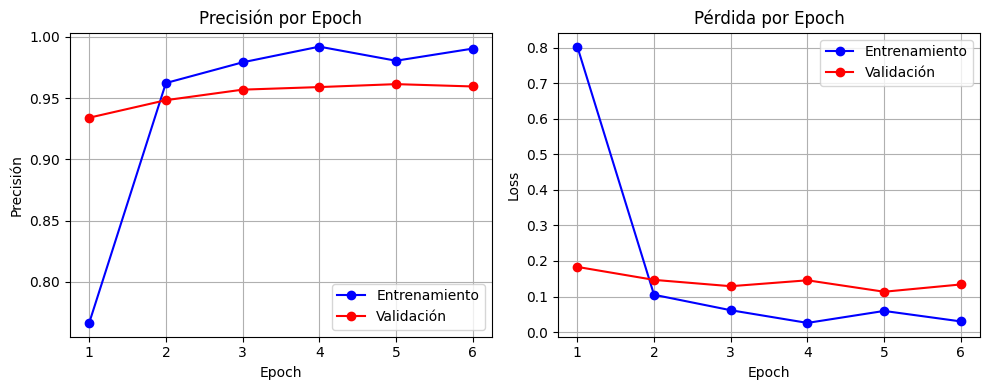

In [ ]:
import matplotlib.pyplot as plt

# Tus datos reales por epoch (puedes añadir más si los tienes)
accuracy =      [0.7666, 0.9624, 0.9793, 0.9921, 0.9806, 0.9905]
val_accuracy =  [0.9341, 0.9484, 0.9570, 0.9591, 0.9615, 0.9596]

loss =          [0.8031, 0.1049, 0.0614, 0.0257, 0.0594, 0.0299]
val_loss =      [0.1833, 0.1468, 0.1290, 0.1456, 0.1134, 0.1339]

epochs = range(1, len(accuracy) + 1)

# Precisión
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_accuracy, 'ro-', label='Validación')
plt.title('Precisión por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Validación')
plt.title('Pérdida por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Parámetros
IMG_SIZE = (128, 128)  # o el tamaño que usaste en entrenamiento

# Ruta de la imagen
img_path = 'ruta/a/la/imagen.jpg'  # o .png

# 1. Cargar y preprocesar la imagen
img = tf.io.read_file(img_path)
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, IMG_SIZE)
img = tf.cast(img, tf.float32) / 255.0  # Normalización
img = tf.expand_dims(img, axis=0)  # Añade dimensión batch

# 2. Hacer la predicción
pred = modelo.predict(img)

# 3. Obtener clase con mayor probabilidad
predicted_class = np.argmax(pred, axis=1)[0]

# 4. Mostrar resultado (opcional)
print(f"Predicción: clase {predicted_class}")

In [ ]:
def df_to_dataset_with_paths(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process(path, label):
        img, label = decode_img(path, label)
        return img, label, path  # añadimos path

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_ds2 = df_to_dataset_with_paths(test_df, shuffle=False)

In [ ]:
results = []

for batch_imgs, batch_labels, batch_paths in test_ds2:
    preds = modelo.predict(batch_imgs)
    pred_classes = np.argmax(preds, axis=1)

    for path, true_label, pred_class, softmax in zip(batch_paths.numpy(), batch_labels.numpy(), pred_classes, preds):
        results.append({
            'ruta': path.decode('utf-8'),
            'label_real': int(true_label),
            'label_predicha': int(pred_class),
            'softmax': softmax
        })

import pandas as pd
df_resultados = pd.DataFrame(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

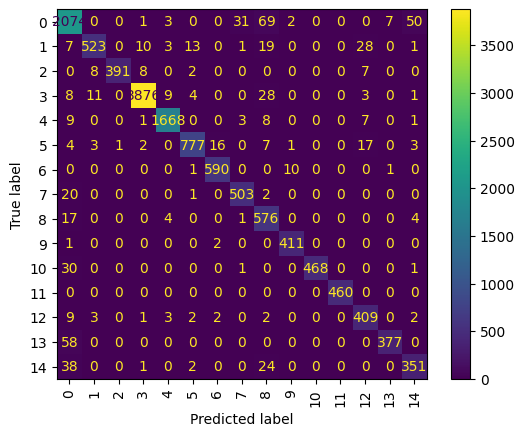

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_resultados['label_real'], df_resultados['label_predicha'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')

In [ ]:
def analizar_softmax(softmax):
    top3 = np.argsort(softmax)[::-1][:3]
    top_scores = softmax[top3]
    return pd.Series({
        'confianza_top1': top_scores[0],
        'clase_top2': top3[1],
        'confianza_top2': top_scores[1],
        'clase_top3': top3[2],
        'confianza_top3': top_scores[2],
        'diferencia_top1_top2': top_scores[0] - top_scores[1],
    })

df_softmax_analisis = df_resultados['softmax'].apply(analizar_softmax)
df_resultados = pd.concat([df_resultados, df_softmax_analisis], axis=1)

Tengo una idea previa de determinar una confianza alta en la predicción o si la confianza en la primera es baja pero la diferencia con la segunda es considerable tomarla como buena  
Mas adelante se verá que no es viable

In [ ]:
# Caso 1: confianza top1 < 0.8
casos_baja_confianza = df_resultados[df_resultados['confianza_top1'] < 0.8]

# Caso 2: confianza top1 < 0.4 o diferencia con top2 < 0.15
casos_dudosos = df_resultados[
    (df_resultados['confianza_top1'] < 0.4) |
    (df_resultados['diferencia_top1_top2'] < 0.15)
]

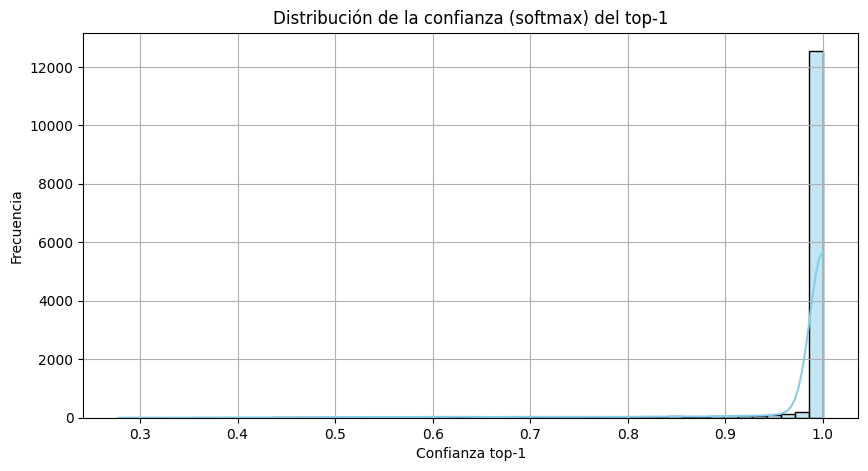

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_resultados['confianza_top1'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de la confianza (softmax) del top-1')
plt.xlabel('Confianza top-1')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

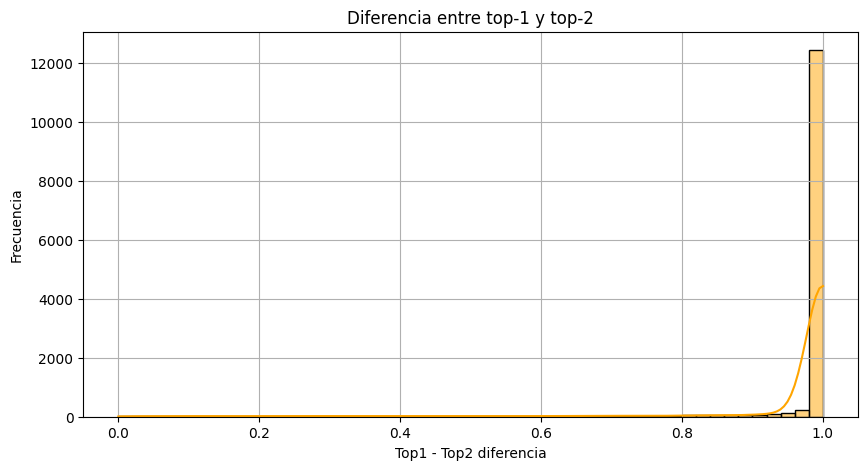

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_resultados['diferencia_top1_top2'], bins=50, kde=True, color='orange')
plt.title('Diferencia entre top-1 y top-2')
plt.xlabel('Top1 - Top2 diferencia')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [ ]:
df_resultados.head()

,ruta,label_real,label_predicha,softmax,confianza_top1,clase_top2,confianza_top2,clase_top3,confianza_top3,diferencia_top1_top2
0,/content/drive/MyDrive/Proyecto Jupiter/archiv...,11,11,"[4.997353e-08, 4.6747733e-10, 1.2464048e-08, 3...",0.999797,8.0,2.015231e-04,4.0,1.139339e-06,0.999595
1,/content/drive/MyDrive/Proyecto Jupiter/archiv...,0,0,"[0.9891829, 2.619408e-06, 6.9053497e-15, 2.697...",0.989183,8.0,4.395085e-03,12.0,3.349808e-03,0.984788
2,/content/drive/MyDrive/Proyecto Jupiter/archiv...,3,3,"[4.035988e-08, 5.9711316e-12, 1.144394e-15, 0....",0.999999,5.0,3.925939e-07,8.0,3.591800e-07,0.999999
3,/content/drive/MyDrive/Proyecto Jupiter/archiv...,12,12,"[2.33515e-06, 8.856956e-08, 3.0886556e-16, 8.1...",0.999998,0.0,2.335150e-06,1.0,8.856956e-08,0.999995
4,/content/drive/MyDrive/Proyecto Jupiter/archiv...,6,6,"[4.36718e-22, 3.5305607e-20, 9.972527e-32, 2.7...",1.000000,9.0,3.392208e-08,5.0,4.643164e-12,1.000000


In [ ]:
df_resultados['acierto'] = df_resultados['label_real'] == df_resultados['label_predicha']

In [ ]:
min_conf_aciertos = df_resultados[df_resultados['acierto']]['confianza_top1'].min()
max_conf_errores = df_resultados[~df_resultados['acierto']]['confianza_top1'].max()

print(f"🔹 Mínima confianza entre aciertos: {min_conf_aciertos:.4f}")
print(f"🔸 Máxima confianza entre errores:  {max_conf_errores:.4f}")

🔹 Mínima confianza entre aciertos: 0.3323
🔸 Máxima confianza entre errores:  1.0000


In [ ]:
errores_confiados = df_resultados[~df_resultados['acierto']].sort_values(by='confianza_top1', ascending=False)
errores_confiados[['ruta', 'label_real', 'label_predicha', 'confianza_top1']].head(10)

,ruta,label_real,label_predicha,confianza_top1
9192,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,6,1.000000
7212,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,12,1.000000
11036,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,5,0.999998
2855,/content/drive/MyDrive/Proyecto Jupiter/archiv...,13,0,0.999985
9276,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,6,0.999961
9665,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,0,0.999954
96,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,5,0.999923
9299,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,8,0.999917
3545,/content/drive/MyDrive/Proyecto Jupiter/archiv...,12,6,0.999914
362,/content/drive/MyDrive/Proyecto Jupiter/archiv...,10,0,0.999827


In [ ]:
errores_confiados.shape

(660, 11)

In [ ]:
errores_confiados[['ruta', 'label_real', 'label_predicha', 'confianza_top1']]

,ruta,label_real,label_predicha,confianza_top1
9192,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,6,1.000000
7212,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,12,1.000000
11036,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,5,0.999998
2855,/content/drive/MyDrive/Proyecto Jupiter/archiv...,13,0,0.999985
9276,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,6,0.999961
...,...,...,...,...
10426,/content/drive/MyDrive/Proyecto Jupiter/archiv...,3,0,0.332729
106,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,14,0.322924
6167,/content/drive/MyDrive/Proyecto Jupiter/archiv...,1,5,0.300362
6623,/content/drive/MyDrive/Proyecto Jupiter/archiv...,4,7,0.291878


In [ ]:
aciertos_confiados = df_resultados[df_resultados['acierto']].sort_values(by='confianza_top1', ascending=False)

In [ ]:
aciertos_confiados[['ruta', 'label_real', 'label_predicha', 'confianza_top1']]

,ruta,label_real,label_predicha,confianza_top1
15,/content/drive/MyDrive/Proyecto Jupiter/archiv...,4,4,1.000000
14,/content/drive/MyDrive/Proyecto Jupiter/archiv...,6,6,1.000000
13,/content/drive/MyDrive/Proyecto Jupiter/archiv...,12,12,1.000000
14111,/content/drive/MyDrive/Proyecto Jupiter/archiv...,3,3,1.000000
9,/content/drive/MyDrive/Proyecto Jupiter/archiv...,4,4,1.000000
...,...,...,...,...
3921,/content/drive/MyDrive/Proyecto Jupiter/archiv...,14,14,0.388141
11426,/content/drive/MyDrive/Proyecto Jupiter/archiv...,3,3,0.384054
2221,/content/drive/MyDrive/Proyecto Jupiter/archiv...,5,5,0.355665
11961,/content/drive/MyDrive/Proyecto Jupiter/archiv...,14,14,0.351932


Vamos a buscar el mejor umbral de confianza que nos retenga la mayor cantidad de aciertos con la menor diferencia de errores y aciertos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Paso 1: rango de posibles umbrales
umbrales = np.linspace(0, 1, 500)

aciertos = df_resultados[df_resultados['acierto']]
errores = df_resultados[~df_resultados['acierto']]

res = []

for u in umbrales:
    aciertos_conf = (aciertos['confianza_top1'] >= u).sum()
    errores_conf = (errores['confianza_top1'] >= u).sum()

    tasa_aciertos = aciertos_conf / len(aciertos)
    tasa_errores = errores_conf / len(errores)

    res.append({
        'umbral': u,
        'tasa_aciertos': tasa_aciertos,
        'tasa_errores': tasa_errores,
        'diferencia': tasa_aciertos - tasa_errores
    })

df_umbral = pd.DataFrame(res)

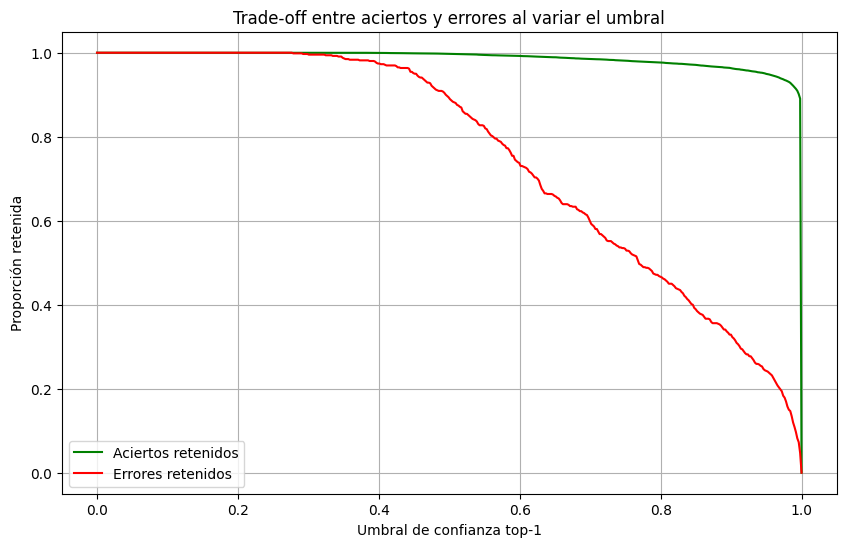

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_umbral['umbral'], df_umbral['tasa_aciertos'], label='Aciertos retenidos', color='green')
plt.plot(df_umbral['umbral'], df_umbral['tasa_errores'], label='Errores retenidos', color='red')
plt.xlabel('Umbral de confianza top-1')
plt.ylabel('Proporción retenida')
plt.title('Trade-off entre aciertos y errores al variar el umbral')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Buscamos el máximo de diferencia entre aciertos y errores retenidos
mejor = df_umbral.loc[df_umbral['diferencia'].idxmax()]
print(f"✅ Mejor umbral: {mejor['umbral']:.4f}")
print(f"   - Aciertos retenidos: {mejor['tasa_aciertos']*100:.2f}%")
print(f"   - Errores retenidos:  {mejor['tasa_errores']*100:.2f}%")
print(f"   - Diferencia:         {mejor['diferencia']*100:.2f}%")

✅ Mejor umbral: 0.9980
   - Aciertos retenidos: 89.07%
   - Errores retenidos:  4.70%
   - Diferencia:         84.37%


El umbral de confianza es muy elevado, por eso el caso anterior de < 0.8 queda descartado

In [ ]:
umbral = 0.9980  # como encontraste antes

df_resultados['automatica'] = df_resultados['confianza_top1'] >= umbral

# Subconjunto que pasaría a producción directamente
automaticas = df_resultados[df_resultados['automatica']]

# De esas, cuántas son errores
errores_automaticos = automaticas[~automaticas['acierto']]

# Cálculo del porcentaje de error entre automáticas
porcentaje_error_auto = len(errores_automaticos) / len(automaticas) * 100
print(f"🔍 Porcentaje de error en predicciones automáticas: {porcentaje_error_auto:.4f}%")

# También puedes calcular por cada 1000 imágenes automáticas:
errores_por_1000 = porcentaje_error_auto * 10
print(f"⚠️ Errores esperados por cada 1000 imágenes procesadas automáticamente: {errores_por_1000:.2f}")

🔍 Porcentaje de error en predicciones automáticas: 0.2581%
⚠️ Errores esperados por cada 1000 imágenes procesadas automáticamente: 2.58


In [ ]:
porcentaje_derivado = 100 * (df_resultados['confianza_top1'] < umbral).mean()
print(f"Porcentaje derivado a revisión humana o LLM: {porcentaje_derivado:.2f}%")

Porcentaje derivado a revisión humana o LLM: 14.89%


El modelo deriva 15 imagenes de cada 100 a la propuesta de LLM o a revisión humana y de cada 10000 comete 25 errores  
Para septiembre que fueron unas 70000 procesaría 59500 imagenes y cometería unos 150 errores.  
Dado que el enunciado indica que los errores sufren fuertes penalizaciones es una opción aceptable pero mejorable